In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import psyfun
import util

## Eye movement strategies in visual search
In this tutorial we will be exploring how human subjects move their eyes around a noisy space to search for a target. Using PsychoPy, we have replicated the visual search task from Najemnik & Geisler (2005) and will use this notebook to analyze the results. The analysis can be broken down into three sections:

1) Analyze target detection performance using methods from classical psychophysics and obtain a "visibility map"
2) Simulate visual searches using the model from Najemnik & Geisler (2005) 
3) Perfom comparative analyses on real and simulated search data

### Psychometric functions
To evaluate stimulus detection at each target eccentricity, let's fit psychometric functions to the data from the 2 alternative forced choice (2AFC) detection task. In this task, participants were asked to keep their eyes fixated at the center of the display, and were shown two noise patches in quick succession. One of the noise patches contained a small Gabor patch (grating). The grating could have one of six contrasts (high contrast = very easy to see, low contrast = impossible to see), and could be presented at one of five distances from the center (eccentricities). For each eccentricity, we fit a psychometric function describing how performance (P(correct)) changes as a function of the logarithm of the grating contrast.

**Q1:** What is the baseline (chance) performance expected from a 2AFC task? \
**Q2:** Why do we log-transform the grating contrasts? \
**Q3:** How does target detection change as a function of eccentricity?

In [3]:
# Load the psychometric detection data
fname_psy = 'data/humans/detection_aggregate.csv'  # file from psychopy detection experiment
df_psy = util.load_psychometric_data(fname_psy)

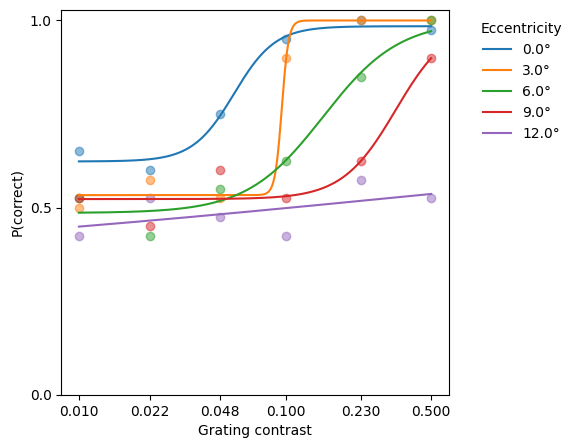

In [4]:
# Create a visibility map object
vismap = psyfun.VisibilityMap(df_psy, log_contrast=True)  

# Fit a psychometric function for each eccentricity 
vismap.fit_psyfuns()

# Plot the psychometric functions and the raw data (mean performance for each level)
fig, ax = plt.subplots(figsize=(5, 5))
vismap.plot_psyfuns(ax=ax)

Our goal is to be able to predict the participants ability to detect the target stimulus for any arbitrary eccentricity (not just those we tested), so we want to see how the parameters of the psychometric function depend on the target eccentricity. Psychometric functions typically have four parameters:
- alpha: the location of the curve on the x-axis, often taken to represent the detection threshold
- beta: the steepness parameter captures the sensitivity of the observer
- gamma: the lower bound of the curve captures the guessing rate
- lambda: the upper bound of the curve captures the lapse rate

Here, we capture the dependency of these parameters on eccentricity using a simple linear model. 

**Q1:** Is a linear model appropriate for every parameter?

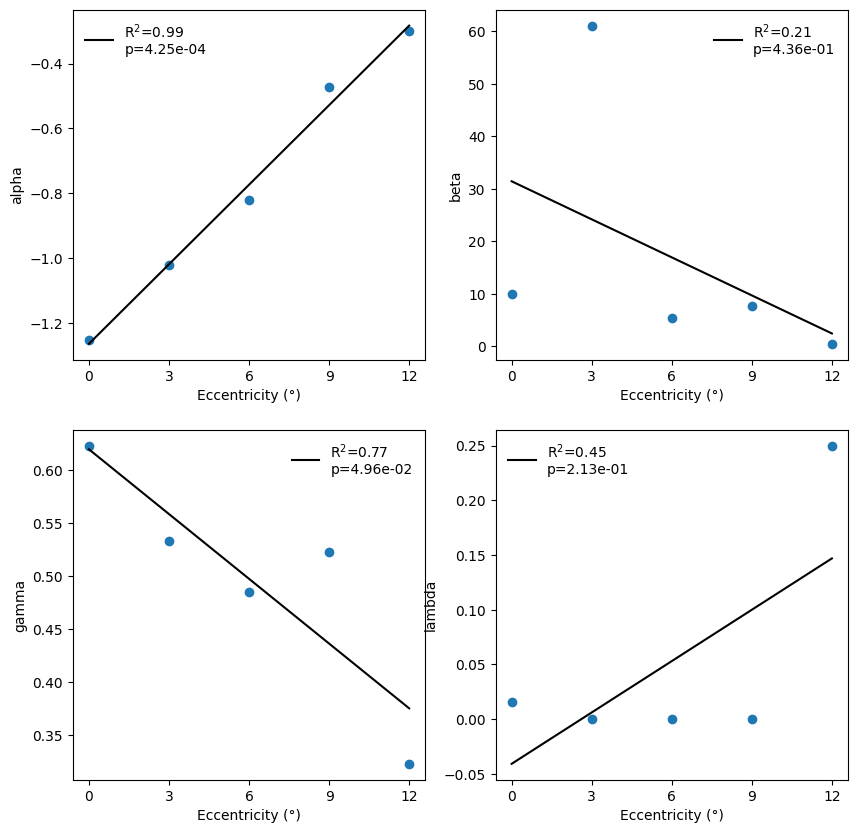

In [5]:
# Fit a linear model to predict what the psychometric function for any eccentricity in the tested range
vismap.interpolate_parameters()

# Plot the linear model for each of the four parameters of the psychometric function
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
for par, ax in zip(vismap.PSYFUNPARS, axs.ravel()):
    ax = vismap.plot_parameter(par, ax=ax)

Now let's check what the predicted psychometric functions look like for the eccentricities we tested.

**Q1:** How do these curves compare to the ones we fit directly to the data?

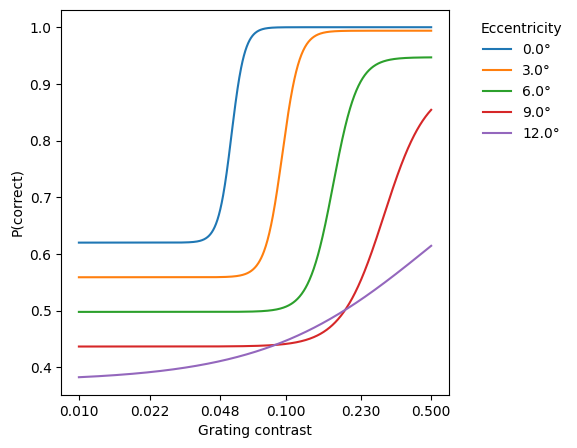

In [6]:
# Plot the modeled psychometric function for each eccentricity
fig, ax = plt.subplots(figsize=(5, 5))
for ecc in vismap.eccentricities:
    # Get the predicted psychometric function for one eccentricity
    pf = vismap.get_psyfun(ecc)
    # Evaluate the psychometric function over a range of contrast values
    xx = np.linspace(vismap.contrast_levels.min(), vismap.contrast_levels.max(), 1000)
    yy = pf(xx)
    # Plot the curve
    ax.plot(xx, yy, label=f'{ecc}\u00b0')

# Format the axes
ax.set_ylabel('P(correct)')
if vismap.log_contrast:  # decide if x axis ticks should be log(contrast)
    xticklabels = [f'{10**c:.3f}' for c in vismap.contrast_levels]
else:
    xticklabels = [f'{c:.3f}' for c in vismap.contrast_levels]
ax.set_xticks(vismap.contrast_levels)
ax.set_xticklabels(xticklabels)
ax.set_xlabel('Grating contrast')
ax.legend(title='Eccentricity', loc=2, bbox_to_anchor=(1.05, 1), frameon=False);

### Visibility Maps
Now that we can model detection performace for a range of contrasts and eccentricities, we are ready to plot some visibility maps! The visual search model constructed by Najemnik and Geisler is based on the assumptions of signal detection theory, and therefore we need to express performance in this same framework. There is a well-known formula used to convert proportion correct in a 2AFC task, and, since we can now model proportion correct for any eccentricity and target contrast, we can also obtain d' (d-prime, visibility) for any eccentricity and contrast. The contrast we will use in the search experiment is 0.1.

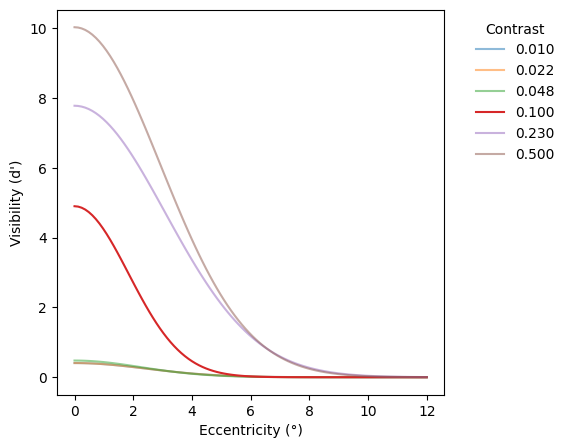

In [7]:
search_contrast = np.log10(0.1)
fig, ax = plt.subplots(figsize=(5, 5))

eccentricities = np.linspace(0, vismap.eccentricities.max(), 100)
for i, contrast in enumerate(vismap.contrast_levels):
    visibility = vismap.vismap(contrast, eccentricities)
    alpha = 1 if contrast == search_contrast else 0.5 
    ax.plot(eccentricities, visibility, alpha=alpha, label=f'{10 ** contrast:.3f}')
ax.set_xlabel('Eccentricity (\u00b0)')
ax.set_ylabel('Visibility (d\')')
ax.legend(title='Contrast', loc=2, bbox_to_anchor=(1.05, 1), frameon=False)

### Simulating a Bayesian searcher
We can use the visibility maps to simulate how a searcher might move their eyes during a search task. Here, we have implemented the "Bayesian searcher" from Najemnik & Geisler (2005). First the model collects a sensory response for each location in the noise patch by multiplying a *template response* (0 if the target is absent, 1 if it is present at the location) with the visibility map extrated from the task above to obtain the sensory response (`S`). The searcher is "Bayesian" because it decides if the target has been detected by combining the *likelihood* of the sensory response assuming the target is at location `i` (`P(S|i)`) with the *prior probability* of the target being located at `i` (`P(i)`) using Bayes law:
    
    `P(i|S) ~ P(S|i)xP(i)` 

where `P(i|S)` is the *posterior probability* that the target is at location `i` given the sensory response. Note that in this very simplified task, the prior is uniform across all locations because the target can appear at any location with equal probability. The model then updates this posterior probability for every possible target location, accumulating information on every fixation. The task is complete when a the posterior distribution for one of the potential locations crosses a certain criterion (C).

**Q1:** What is the role of the prior in this task setting?
    
The "optimal" search model will also use the posterior distributions to guide its eye movements, using $P(i|W)$ to choose a fixation target that maximizes its chances of identifying the target after the next saccade.

    argmax( P(i|S)_T > C | i, k(T+1) )

Where k is a potential future fixation target, and T is the current fixation number.
 
**Q2:** What are some other strategies a searcher might use to selecting the next fixation target?

Now, we will simulate one trial of the visual search task using Bayesian optimal search model.

**Q3:** What is the eccentricity of the target in the trial below? \
**Q4:** What happens to the posterior probabilities as the model fixates a part of the screen?

In [8]:
# Set the target parameters for this trial
target_contrast = np.log10(0.2)  # set a relatively easy target contrast
target_x, target_y = (5, 5)  # set a target position using x,y coordinates

# Instantiate the model searcher using the vismap we generated above
searcher = psyfun.BayesianOptimalSearcher(vismap, criterion=0.99)
searcher.initialize_trial(target_x, target_y, target_contrast)
searcher.search(plot=True)

KeyboardInterrupt: 

> /home/crombie/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py(2322)any()
   2320 
   2321 
-> 2322 @array_function_dispatch(_any_dispatcher)
   2323 def any(a, axis=None, out=None, keepdims=np._NoValue, *, where=np._NoValue):
   2324     """



ipdb>  c


### Human visual search data 
Load the data from our replication of the Najemnik & Geisler (2005, Nature) search task.

In [ ]:
# Load the visual search data
fname_search = 'data/humans/search_aggregate.pkl'  # aggregate data from several participants
df_search = pd.read_pickle(fname_search)

In [1]:
# Plot the distribution of search durations
fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.hist(df_search['trial_duration'] / 10**9, histtype='step', lw=2)
ax.set_xlabel('Search time (s)')
ax.set_ylabel('Trials')

NameError: name 'plt' is not defined

> /tmp/ipykernel_427098/2336435347.py(2)<module>()
      1 # Plot the distribution of search durations
----> 2 fig, ax = plt.subplots(figsize=(2.5, 2.5))
      3 ax.hist(df_search['trial_duration'] / 10**9, histtype='step', lw=2)
      4 ax.set_xlabel('Search time (s)')
      5 ax.set_ylabel('Trials')



ipdb>  
ipdb>  c


Let's see what the fixations and saccades look like for a random sample of trials.

**Q1:** Why might the central and final fixation targets seem slightly off here?

In [ ]:
# Keep re-running this cell to get a samples of trials
trials = np.random.choice(df_search.index, 9)

fig, axs = plt.subplots(3, 3, figsize=(10, 10))
for trial, ax in zip(trials, axs.ravel()):
    ax = util.plot_search_trial(trial, df_search, ax=ax)

Now let's try to replicate some findings from Najemnik & Geisler (2005). In Figure 4b they showed that there is a dependence of the number of fixations in a trial on the target eccentricity.

**Q1:** Were the results from Najemnik & Geisler replicated? \
**Q2:** What would be an appropriate statistical test to check this result?

In [ ]:
# Group the data by the target eccentricity and find the mean and standard error
n_fix = df_search.groupby('grating_eccentricity')['n_fixations'].mean()
ci = df_search.groupby('grating_eccentricity')['n_fixations'].sem() * 1.96  # approxiamtion for a 95% confidence interval
ecc = np.sort(df_search['grating_eccentricity'].unique())  # eccentricity levels used in this task

# Make a plot with the mean number of fixations and error bars representing the 95% CI
fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.errorbar(ecc, n_fix, yerr=ci)
ax.set_xticks(np.arange(0, ecc.max() + 4, 2))
ax.set_xlabel('Target eccentricity (\u00b0)')
ax.set_yticks(np.arange(0, 25, 5))
ax.set_ylabel('Number of Fixations');

Below we examine two further characteristics of eye movements during visual search that were reported by Najemnik & Geisler, although without an accompanying figure. The first observation is that saccade lengths have a skewed distribution with a peak/ median at approximately 3 degrees.

**Q1:** Why do saccade lengths tend to be "moderate in size"? \
**Q2:** What hypothesis do Najemnik & Geisler suggest for the prominent tail of longer saccades? 

In [ ]:
# Concatenate saccade lengths for all trials
lengths = np.concatenate(df_search['saccade_lengths'].values)

# Plot the overall distribution of saccade lengths and the median
fig, ax = plt.subplots(figsize=(2.5, 2.5))
weights = np.ones_like(lengths) / len(lengths)
counts, _, _ = ax.hist(lengths, weights=weights, histtype='step', lw=2)
ax.scatter(np.nanmedian(lengths), counts.max() + 0.01, marker='v', lw=2, ec='black', fc='none') 
ax.set_xticks(np.arange(0, 20, 5))
ax.set_xlabel('Saccade length (\u00b0)')
ax.set_ylabel('Probability')

The second observation is that fixation locations should be distributed in a "doughnut" shape around the center at intermediate distances.

**Q1:** Why might such a distribution arise, according to the model? \
**Q2:** Does our observed spatial distribution look like a doughnut? Does our distribution suggest an particular search strategy?

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))
ax = util.plot_fixation_distribution(df_search, ax=ax)  # note: the initial central fixation is removed from consideration

### Comparing humans to the Bayesian optimal searcher
Now that we have extracted some characteristics of human eye movements during visual search, and we have a model that can perform the search task, let's see if the model has the same characteristics as the humans! Below we load the data where the Bayesian optimal searcher was used to simulate multiple search trials, and plot the search trajectories for a few example trials.

In [9]:
df_search = pd.read_pickle('data/models/bayesian_optimal_01.pkl')
df_search['grating_eccentricity'] = df_search['grating_eccentricity'].apply(round)  # fix weird behavior with floats

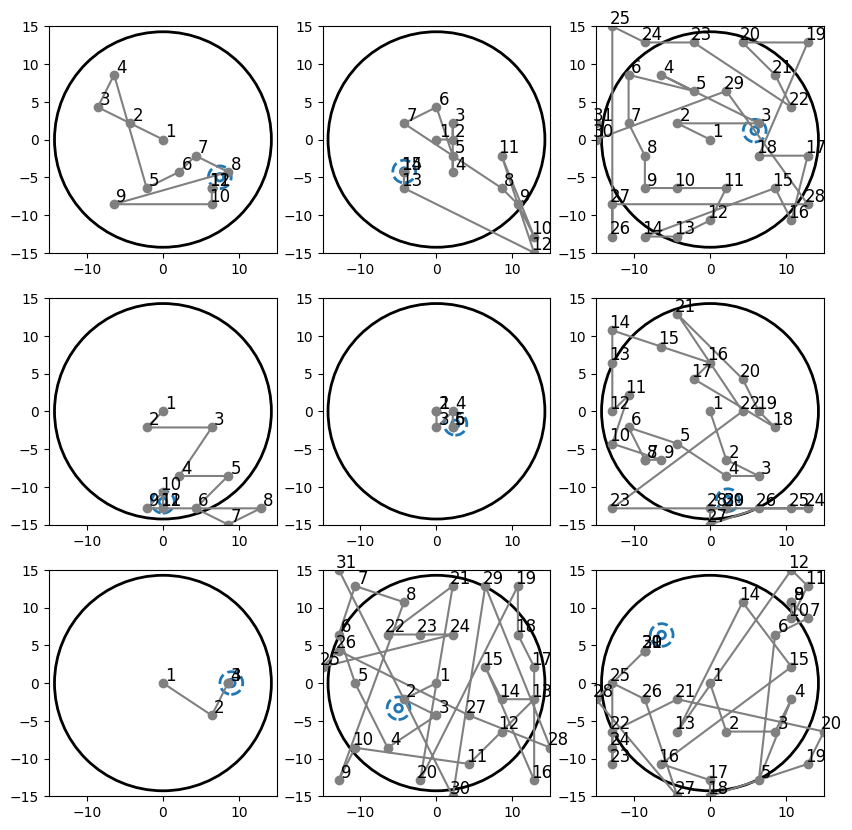

In [10]:
# Keep re-running this cell to get a samples of trials
trials = np.random.choice(df_search.index, 9)

fig, axs = plt.subplots(3, 3, figsize=(10, 10))
for trial, ax in zip(trials, axs.ravel()):
    ax = util.plot_search_trial(trial, df_search, ax=ax)

Next let's check if this instantiation of the model reproduces the eye movements of the human searchers, such as the saccade length distribution and the spatial distribution of fixations.

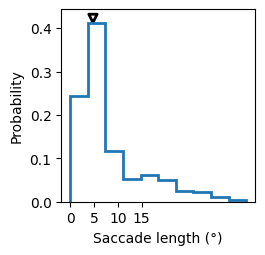

In [11]:
# Concatenate saccade lengths for all trials
lengths = np.concatenate(df_search['saccade_lengths'].values)

# Plot the overall distribution of saccade lengths and the median
fig, ax = plt.subplots(figsize=(2.5, 2.5))
weights = np.ones_like(lengths) / len(lengths)
counts, _, _ = ax.hist(lengths, weights=weights, histtype='step', lw=2)
ax.scatter(np.nanmedian(lengths), counts.max() + 0.01, marker='v', lw=2, ec='black', fc='none') 
ax.set_xticks(np.arange(0, 20, 5))
ax.set_xlabel('Saccade length (\u00b0)')
ax.set_ylabel('Probability');

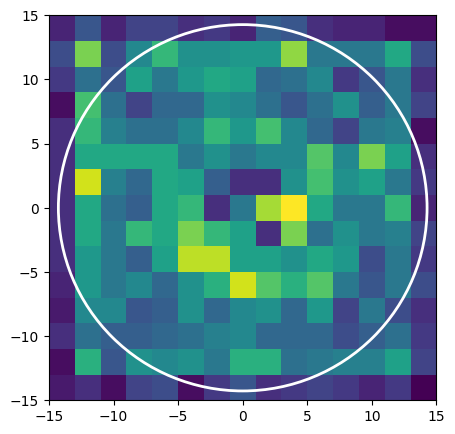

In [12]:
fig, ax = plt.subplots(figsize=(5, 5))
ax = util.plot_fixation_distribution(df_search, ax=ax)  # note: the initial central fixation is removed from consideration

Finally, we can ask if our model searcher also has a dependence of the number of fixations on the target eccentricity. That is, does the model also take longer to find targets that are further away from the central fixation point?

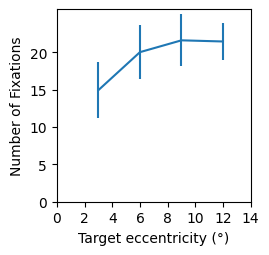

In [13]:
# Group the data by the target eccentricity and find the mean and standard error
n_fix = df_search.groupby('grating_eccentricity')['n_fixations'].mean()
ci = df_search.groupby('grating_eccentricity')['n_fixations'].sem() * 1.96  # approxiamtion for a 95% confidence interval
ecc = np.sort(df_search['grating_eccentricity'].unique())  # eccentricity levels used in this task

# Make a plot with the mean number of fixations and error bars representing the 95% CI
fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.errorbar(ecc, n_fix, yerr=ci)
ax.set_xticks(np.arange(0, ecc.max() + 4, 2))
ax.set_xlabel('Target eccentricity (\u00b0)')
ax.set_yticks(np.arange(0, 25, 5))
ax.set_ylabel('Number of Fixations');

### Exercises

#### Exercise 1: Sub-optimal searchers 
Above we explored a Bayesian searcher that is "optimal" because it selects future fixation targets by maximizing it's chances of being correct based on what it knows. In their paper, Najemnik & Geisler explore two further models of how eye movements may be directed around the visual scene. The first model is called a random searcher; while it still computes the posterior probabilties to decide where the target might be, it doesn't use this information to select fixation targets, it picks at random. The second alternative model is the MAP searcher, which stands for "maximum *a posteriori*" fixation selection. This model selects fixation locations by taking the maximum of the current posterior distribution. In other words, the searcher always moves its eyes to its estimate of the most likely target location.

Your task below is to implement these two alternative search models and simulate a few trials with each. You will do this by creating "sub-classes" of the Bayesian searcher. These classes inherit everything from the Bayesian searcher, except for the method that generates saccades. Modify the `make_saccade` method so that the models produce the desired behavior.

In [ ]:
class BayesianRandomSearcher(BayesianSearcher):

    def make_saccade(self):
        # Check if criterion is met
        if self.P[self.fix_n].max() >= self.criterion:
            new_location = np.argmax(self.P[self.fix_n])  # saccade to target
            self.target_located = True
        else:
            new_location =  # hint: all possible locations are stored in self.LOCS
        self.fix_n += 1
        self.I[self.fix_n] = new_location

In [ ]:
class BayesianMAPSearcher(BayesianSearcher):

    def make_saccade(self):
        # Check if criterion is met
        if self.P[self.fix_n].max() >= self.criterion:
            new_location = np.argmax(self.P[self.fix_n])  # saccade to target
            self.target_located = True
        else:
            new_location =  # hint: the posterior distributions for each fixation are stored in self.P
        self.fix_n += 1
        self.I[self.fix_n] = new_location

#### Exercise 2: Investigating the role of the prior

The task that we have asked the model to do only uses half of the model! In a scene of pure noise and random target positions, there is no role for expectations or prior knowledge. How would you modify the task to introduce a role for the prior? Update the Bayesian optimal searcher to be influenced by the prior in a way that is useful for your new task.

In [ ]:
class BayesianOptimalSearcher(BayesianSearcher):

    def make_saccade(self):
        # Check if criterion is met
        if self.P[self.fix_n].max() >= self.criterion:
            new_location = np.argmax(self.P[self.fix_n])  # saccade to target
            self.target_located = True
            print("Target located!")
        else:
            new_location = np.argmax(self.P_C[self.fix_n])
        self.fix_n += 1
        self.I[self.fix_n] = new_location

    def update_prior(self):
        # Your code goes here
        # hint: the prior is stored in self.prior
        # hint: the uniform prior is initialized as self.prior = 1 / self.N_BINS**2
        # hint: the prior is 1D ("unraveled"), if we want to manipulate it in 2D we
        #       have to first reshape it using self.prior.reshape(self.SHAPE)